# Данные по инсультам

Выведем информацию о столбцах датасета:

In [1]:
import pandas as pd
from sklearn import set_config

set_config(transform_output="pandas")

random_state=9

df = pd.read_csv("./csv/option4.csv", index_col="id")

df

gender   age  hypertension  heart_disease ever_married      work_type  \
id                                                                             
9046     Male  67.0             0              1          Yes        Private   
51676  Female  61.0             0              0          Yes  Self-employed   
31112    Male  80.0             0              1          Yes        Private   
60182  Female  49.0             0              0          Yes        Private   
1665   Female  79.0             1              0          Yes  Self-employed   
...       ...   ...           ...            ...          ...            ...   
18234  Female  80.0             1              0          Yes        Private   
44873  Female  81.0             0              0          Yes  Self-employed   
19723  Female  35.0             0              0          Yes  Self-employed   
37544    Male  51.0             0              0          Yes        Private   
44679  Female  44.0             0              0          Yes       Govt_job   

      Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
id                                                                      
9046           Urban             228.69  36.6  formerly smoked       1  
51676          Rural             202.21   NaN     never smoked       1  
31112          Rural             105.92  32.5     never smoked       1  
60182          Urban             171.23  34.4           smokes       1  
1665           Rural             174.12  24.0     never smoked       1  
...              ...                ...   ...              ...     ...  
18234          Urban              83.75   NaN     never smoked       0  
44873          Urban             125.20  40.0     never smoked       0  
19723          Rural              82.99  30.6     never smoked       0  
37544          Rural             166.29  25.6  formerly smoked       0  
44679          Urban              85.28  26.2          Unknown       0  

[5110 rows x 11 columns]

### Бизнес-цели
#### Классификация
##### Цель: сделать модель, которая на основе данных про здоровье, образ жизни и соцдем-факторы будет предсказывать риск инсульта.

Применение:
Для врачей: чтобы находить пациентов с высоким риском и вовремя их спасать.
Для медсистем: можно встроить в карты пациентов, чтобы система сама предупреждала врача.
Для людей: повышать осведомленность о факторах риска и как их избежать.

#### Регрессия
##### Цель: сделать модель, которая будет предсказывать уровень глюкозы на основе тех же факторов. Поможет отслеживать изменения и оценивать риски.

Применение:
Для врачей: находить пациентов с риском диабета и другими проблемами, чтобы сразу назначать профилактику.
Для медсистем: встроить в записи пациентов, чтобы врачи видели уровень глюкозы даже без лабораторий.
Для населения: обучать, как lifestyle влияет на глюкозу, и рекомендовать изменения.

### Качество моделей
#### Классификация (инсульт):

Признаки норм: возраст, гипертония, сердце — инфа полезная, модель будет неплохо различать риск.
Проблемы: нет данных про гены, детальную историю болезней, питание, физнагрузки. Это режет потолок точности.

#### Регрессия (глюкоза):
Признаки норм: возраст, курение, давление — связь с глюкозой есть, что-то предскажет.
Проблемы: не хватает данных про еду, активность, гормоны, поэтому точность ограничена.

## Классификация

Разделим набор данных на на обучающую и тестовые выборки (80/20). Целевой признак - stroke

In [2]:
from typing import Tuple
from pandas import DataFrame
from sklearn.model_selection import train_test_split

def split_stratified_into_train_val_test(
    df_input,
    stratify_colname="y",
    frac_train=0.6,
    frac_val=0.15,
    frac_test=0.25,
    random_state=None,
) -> Tuple[DataFrame, DataFrame, DataFrame, DataFrame, DataFrame, DataFrame]:

    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError(
            "fractions %f, %f, %f do not add up to 1.0"
            % (frac_train, frac_val, frac_test)
        )

    if stratify_colname not in df_input.columns:
        raise ValueError("%s is not a column in the dataframe" % (stratify_colname))

    X = df_input  # Contains all columns.
    y = df_input[
        [stratify_colname]
    ]  # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(
        X, y, stratify=y, test_size=(1.0 - frac_train), random_state=random_state
    )

    if frac_val <= 0:
        assert len(df_input) == len(df_train) + len(df_temp)
        return df_train, pd.DataFrame(), df_temp, y_train, pd.DataFrame(), y_temp

    # Split the temp dataframe into val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(
        df_temp,
        y_temp,
        stratify=y_temp,
        test_size=relative_frac_test,
        random_state=random_state,
    )

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)
    return df_train, df_val, df_test, y_train, y_val, y_test

In [3]:
X_train, X_val, X_test, y_train, y_val, y_test = split_stratified_into_train_val_test(
    df, stratify_colname="stroke", frac_train=0.80, frac_val=0, frac_test=0.20, random_state=random_state
)

display("X_train", X_train)
display("y_train", y_train)

display("X_test", X_test)
display("y_test", y_test)

'X_train'

gender   age  hypertension  heart_disease ever_married      work_type  \
id                                                                             
22159  Female  54.0             1              0           No        Private   
8920   Female  51.0             0              0          Yes  Self-employed   
65507    Male  33.0             0              0          Yes        Private   
43196  Female  52.0             0              0          Yes  Self-employed   
59745  Female  27.0             0              0          Yes        Private   
...       ...   ...           ...            ...          ...            ...   
66546  Female  20.0             0              0           No        Private   
68798  Female  58.0             0              0          Yes        Private   
61409    Male  32.0             1              0           No       Govt_job   
69259  Female  77.0             0              0          Yes        Private   
17231  Female  24.0             0              0           No        Private   

      Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
id                                                                      
22159          Urban              97.06  28.5  formerly smoked       0  
8920           Rural              76.35  33.5  formerly smoked       0  
65507          Rural              55.72  38.2     never smoked       0  
43196          Urban              59.54  42.2          Unknown       0  
59745          Urban              76.74  53.9          Unknown       0  
...              ...                ...   ...              ...     ...  
66546          Urban              80.08  25.1     never smoked       0  
68798          Rural              59.86  28.0  formerly smoked       1  
61409          Urban              58.24   NaN  formerly smoked       0  
69259          Rural             100.85  29.5           smokes       0  
17231          Urban              90.42  24.3     never smoked       0  

[4088 rows x 11 columns]

'y_train'

stroke
id           
22159       0
8920        0
65507       0
43196       0
59745       0
...       ...
66546       0
68798       1
61409       0
69259       0
17231       0

[4088 rows x 1 columns]

'X_test'

gender   age  hypertension  heart_disease ever_married      work_type  \
id                                                                             
18072  Female  39.0             0              0          Yes       Govt_job   
67063    Male  62.0             0              0          Yes  Self-employed   
40387  Female  17.0             0              0           No        Private   
18032    Male  62.0             0              1          Yes        Private   
5478   Female  60.0             0              0          Yes  Self-employed   
...       ...   ...           ...            ...          ...            ...   
57710  Female  50.0             0              0          Yes        Private   
63043  Female  27.0             0              0           No        Private   
63986    Male  60.0             0              0          Yes        Private   
28461    Male  15.0             0              0           No   Never_worked   
54975    Male   7.0             0              0           No  Self-employed   

      Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
id                                                                      
18072          Urban             107.47  21.3          Unknown       0  
67063          Urban             130.56  36.1          Unknown       0  
40387          Rural              77.46  24.0          Unknown       0  
18032          Rural              90.61  25.8           smokes       0  
5478           Urban             203.04   NaN           smokes       0  
...              ...                ...   ...              ...     ...  
57710          Rural             112.25  21.6          Unknown       0  
63043          Urban              61.80  26.8  formerly smoked       0  
63986          Rural             153.48  37.3     never smoked       0  
28461          Rural              79.59  28.4          Unknown       0  
54975          Rural              64.06  18.9          Unknown       0  

[1022 rows x 11 columns]

'y_test'

stroke
id           
18072       0
67063       0
40387       0
18032       0
5478        0
...       ...
57710       0
63043       0
63986       0
28461       0
54975       0

[1022 rows x 1 columns]

Выберем ориентир для задачи классификации. Для этого применим алгоритм случайного предсказания, т.е. в каждом случае в качестве предсказания выберем случайный класс.

In [4]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# Получаем уникальные классы для целевого признака из тренировочного набора данных
unique_classes = np.unique(y_train)

# Генерируем случайные предсказания, выбирая случайное значение из области значений целевого признака
random_predictions = np.random.choice(unique_classes, size=len(y_test))

# Вычисление метрик для ориентира
baseline_accuracy = accuracy_score(y_test, random_predictions)
baseline_precision = precision_score(y_test, random_predictions)
baseline_recall = recall_score(y_test, random_predictions)
baseline_f1 = f1_score(y_test, random_predictions)

print('Baseline Accuracy:', baseline_accuracy)
print('Baseline Precision:', baseline_precision)
print('Baseline Recall:', baseline_recall)
print('Baseline F1 Score:', baseline_f1)

Baseline Accuracy: 0.5
Baseline Precision: 0.05758157389635317
Baseline Recall: 0.6
Baseline F1 Score: 0.10507880910683012


#### Метрики модели
- Accuracy: доля правильных предсказаний от общего числа примеров. Простая, но бесполезная метрика в задачах с дисбалансом классов — не учитывает, как модель работает с редким классом.
- Precision: доля правильных предсказаний положительного класса среди всех предсказанных положительных. Полезна, если критичны ложные срабатывания (например, чтобы не ошибаться с инсультом).
- Recall: доля найденных объектов положительного класса среди всех реальных примеров положительного класса. Помогает понять, насколько хорошо модель "ловит" положительный класс. Важна, чтобы минимизировать пропуски инсультов.
- F1 Score: гармоническое среднее между precision и recall. Учитывает и точность, и полноту, что важно в задачах с несбалансированными классами.
Эти метрики показывают разные аспекты работы модели: от общего уровня точности до способности находить редкие классы и балансировать между precision и recall. Это позволяет оценить модель всесторонне.

### Сформируем конвейер для классификации

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

columns_to_drop = ["work_type", "stroke"]
columns_not_to_modify = ["hypertension", "heart_disease"]

num_columns = [
    column
    for column in df.columns
    if column not in columns_to_drop
    and column not in columns_not_to_modify
    and df[column].dtype != "object"
]

cat_columns = [
    column
    for column in df.columns
    if column not in columns_to_drop
    and column not in columns_not_to_modify
    and df[column].dtype == "object"
]

num_imputer = SimpleImputer(strategy="median")
num_scaler = StandardScaler()
preprocessing_num = Pipeline(
    [
        ("imputer", num_imputer),
        ("scaler", num_scaler),
    ]
)

cat_imputer = SimpleImputer(strategy="constant", fill_value="unknown")
cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")
preprocessing_cat = Pipeline(
    [
        ("imputer", cat_imputer),
        ("encoder", cat_encoder),
    ]
)

features_preprocessing = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ("prepocessing_num", preprocessing_num, num_columns),
        ("prepocessing_cat", preprocessing_cat, cat_columns),
    ],
    remainder="passthrough"
)

drop_columns = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ("drop_columns", "drop", columns_to_drop),
    ],
    remainder="passthrough",
)

pipeline_end = Pipeline(
    [
        ("features_preprocessing", features_preprocessing),
        ("drop_columns", drop_columns),
    ]
)

Теперь проверим работу конвейера:

In [6]:
preprocessing_result = pipeline_end.fit_transform(X_train)
preprocessed_df = pd.DataFrame(
    preprocessing_result,
    columns=pipeline_end.get_feature_names_out(),
)

preprocessed_df

age  avg_glucose_level       bmi  gender_Male  gender_Other  \
id                                                                        
22159  0.472344          -0.194427 -0.059214          0.0           0.0   
8920   0.339807          -0.653763  0.587887          0.0           0.0   
65507 -0.455418          -1.111325  1.196162          1.0           0.0   
43196  0.383986          -1.026600  1.713843          0.0           0.0   
59745 -0.720492          -0.645113  3.228060          0.0           0.0   
...         ...                ...       ...          ...           ...   
66546 -1.029746          -0.571034 -0.499243          0.0           0.0   
68798  0.649060          -1.019502 -0.123924          0.0           0.0   
61409 -0.499597          -1.055433 -0.098040          1.0           0.0   
69259  1.488464          -0.110367  0.070206          0.0           0.0   
17231 -0.853030          -0.341699 -0.602779          0.0           0.0   

       ever_married_Yes  Residence_type_Urban  smoking_status_formerly smoked  \
id                                                                              
22159               0.0                   1.0                             1.0   
8920                1.0                   0.0                             1.0   
65507               1.0                   0.0                             0.0   
43196               1.0                   1.0                             0.0   
59745               1.0                   1.0                             0.0   
...                 ...                   ...                             ...   
66546               0.0                   1.0                             0.0   
68798               1.0                   0.0                             1.0   
61409               0.0                   1.0                             1.0   
69259               1.0                   0.0                             0.0   
17231               0.0                   1.0                             0.0   

       smoking_status_never smoked  smoking_status_smokes  hypertension  \
id                                                                        
22159                          0.0                    0.0             1   
8920                           0.0                    0.0             0   
65507                          1.0                    0.0             0   
43196                          0.0                    0.0             0   
59745                          0.0                    0.0             0   
...                            ...                    ...           ...   
66546                          1.0                    0.0             0   
68798                          0.0                    0.0             0   
61409                          0.0                    0.0             1   
69259                          0.0                    1.0             0   
17231                          1.0                    0.0             0   

       heart_disease  
id                    
22159              0  
8920               0  
65507              0  
43196              0  
59745              0  
...              ...  
66546              0  
68798              0  
61409              0  
69259              0  
17231              0  

[4088 rows x 12 columns]

Подберем оптимальные гиперпараметры для каждой из выбранных моделей методом поиска по сетке и сформируем их набор.

knn -- k-ближайших соседей

random_forest -- метод случайного леса (набор деревьев решений)

mlp -- многослойный персептрон (нейронная сеть)

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn import neighbors, ensemble, neural_network

# Словарь с вариантами гиперпараметров для каждой модели
param_grids = {
    "knn": {
        "n_neighbors": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 
        "weights": ['uniform', 'distance']
    },
    "random_forest": {
        "n_estimators": [10, 20, 30, 40, 50, 100, 150, 200, 250, 500],
        "max_features": ["sqrt", "log2", 2],
        "max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10],
        "criterion": ["gini", "entropy", "log_loss"],
        "random_state": [random_state],
        "class_weight": ["balanced", "balanced_subsample"]
    },
    "mlp": {
        "solver": ['adam'], 
        "max_iter": [1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000], 
        "alpha": 10.0 ** -np.arange(1, 10), 
        "hidden_layer_sizes":np.arange(10, 15), 
        "early_stopping": [True, False],
        "random_state": [random_state]
    }
}

# Создаем экземпляры моделей
models = {
    "knn": neighbors.KNeighborsClassifier(),
    "random_forest": ensemble.RandomForestClassifier(),
    "mlp": neural_network.MLPClassifier()
}

# Словарь для хранения моделей с их лучшими параметрами
class_models = {}

# Выполнение поиска по сетке для каждой модели
for model_name, model in models.items():
    # Создаем GridSearchCV для текущей модели
    gs_optimizer = GridSearchCV(estimator=model, param_grid=param_grids[model_name], scoring="f1", n_jobs=-1)
    
    # Обучаем GridSearchCV
    gs_optimizer.fit(preprocessed_df, y_train.values.ravel())
    
    # Получаем лучшие параметры
    best_params = gs_optimizer.best_params_
    print(f"Лучшие параметры для {model_name}: {best_params}")
    
    class_models[model_name] = {
        "model": model.set_params(**best_params)  # Настраиваем модель с лучшими параметрами
    }

d:\code\mai\labs\AIM-PIbd-31-Bakalskaya-E-D\lab_4\venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Лучшие параметры для knn: {'n_neighbors': 1, 'weights': 'uniform'}
Лучшие параметры для random_forest: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 50, 'random_state': 9}
Лучшие параметры для mlp: {'alpha': np.float64(0.1), 'early_stopping': True, 'hidden_layer_sizes': np.int64(14), 'max_iter': 1000, 'random_state': 9, 'solver': 'adam'}


#### ЖЕСТЬ ЭТА ХРЕНЬ 12 МИНУТ СОЗДАВАЛАСЬ...

что ж теперь... обучим модели разными способами модели и посмотрим на качество обучения

In [22]:
from sklearn.metrics import confusion_matrix

for model_name in class_models.keys():
    print(f"Model: {model_name}")
    model = class_models[model_name]["model"]

    model_pipeline = Pipeline([("pipeline", pipeline_end), ("model", model)])
    model_pipeline = model_pipeline.fit(X_train, y_train.values.ravel())

    y_train_predict = model_pipeline.predict(X_train)
    y_test_probs = model_pipeline.predict_proba(X_test)[:, 1]
    y_test_predict = np.where(y_test_probs > 0.5, 1, 0)

    class_models[model_name]["pipeline"] = model_pipeline
    class_models[model_name]["probs"] = y_test_probs
    class_models[model_name]["preds"] = y_test_predict

    class_models[model_name]["Precision_train"] = precision_score(
        y_train, y_train_predict
    )
    class_models[model_name]["Precision_test"] = precision_score(
        y_test, y_test_predict
    )
    class_models[model_name]["Recall_train"] = recall_score(
        y_train, y_train_predict
    )
    class_models[model_name]["Recall_test"] = recall_score(
        y_test, y_test_predict
    )
    class_models[model_name]["Accuracy_train"] = accuracy_score(
        y_train, y_train_predict
    )
    class_models[model_name]["Accuracy_test"] = accuracy_score(
        y_test, y_test_predict
    ) 
    class_models[model_name]["F1_train"] = f1_score(y_train, y_train_predict)
    class_models[model_name]["F1_test"] = f1_score(y_test, y_test_predict)
    class_models[model_name]["Confusion_matrix"] = confusion_matrix(
        y_test, y_test_predict
    )

Model: knn


ValueError: A given column is not a column of the dataframe

Матрицы неточностей:

['model', 'pipeline', 'train_preds', 'preds', 'RMSE_train', 'RMSE_test', 'RMAE_test', 'R2_test']


KeyError: 'Confusion_matrix'

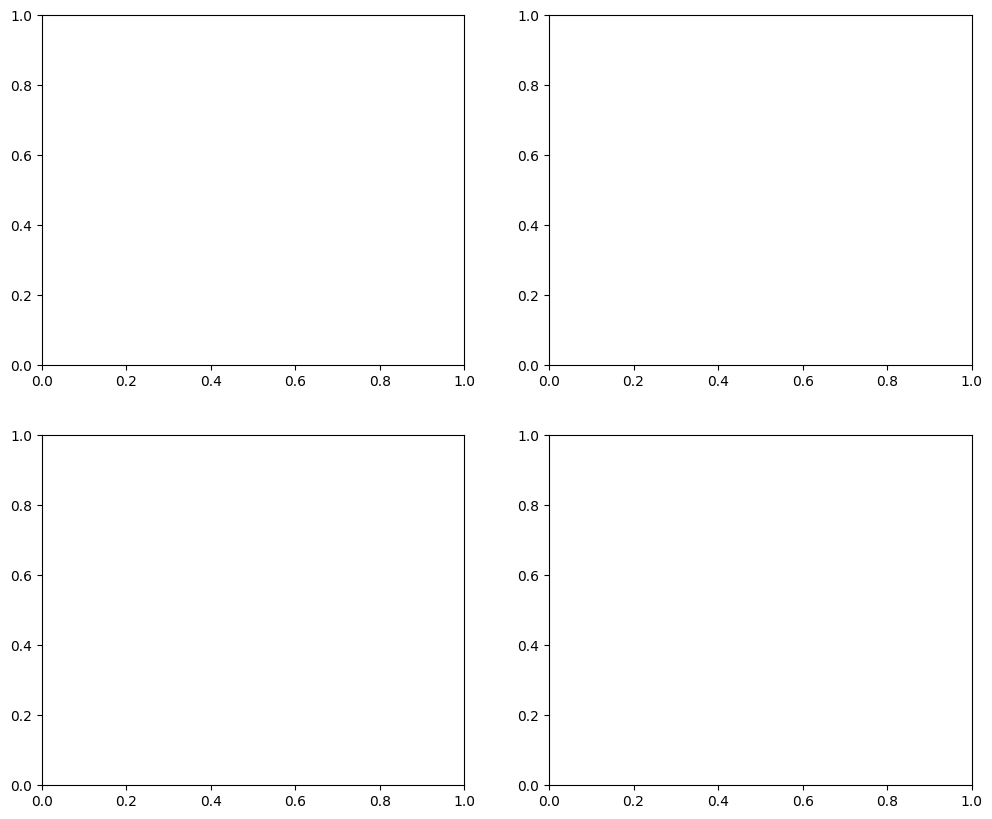

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(12, 10))

for index, (key, model_info) in enumerate(class_models.items()):
    print(list(model_info.keys()))
    c_matrix = model_info["Confusion_matrix"]
    
    disp = ConfusionMatrixDisplay(
        confusion_matrix=c_matrix, display_labels=["Not stroke", "Stroke"]
    ).plot(ax=ax.flat[index])
    
    disp.ax_.set_title(key)

if len(class_models) < len(ax.flat):
    for i in range(len(class_models), len(ax.flat)):
        fig.delaxes(ax.flat[i])

plt.subplots_adjust(top=0.9, bottom=0.1, hspace=0.4, wspace=0.3)

plt.show()

Precision, Recall, Accuracy, F1:

In [10]:
class_metrics = pd.DataFrame.from_dict(class_models, "index")[
    [
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
        "Accuracy_train",
        "Accuracy_test",
        "F1_train",
        "F1_test",
    ]
]
class_metrics.sort_values(
    by="Accuracy_test", ascending=False
).style.background_gradient(
    cmap="plasma",
    low=0.3,
    high=1,
    subset=["Accuracy_train", "Accuracy_test", "F1_train", "F1_test"],
).background_gradient(
    cmap="viridis",
    low=1,
    high=0.3,
    subset=[
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
    ],
)

#### Анализ моделей:
##### MLP (многослойный перцептрон):
Точность (Accuracy): 95% (обучение и тест).
Precision и Recall: крайне низкие (0.40 и 0.02 на обучении, 0.20 и 0.02 на тесте).
F1-метрика: практически нулевая (0.038 и 0.037).
Вывод: модель хорошо определяет общий класс, но почти не замечает положительные примеры.

##### KNN (K-ближайшие соседи):
Обучение: идеальные метрики (1.0).
Тест: резкое падение (Precision 0.118, Recall 0.12, Accuracy 91%).
Вывод: переобучение. Отлично работает на обучении, но плохо обобщает на новых данных.

##### Random Forest (случайный лес):
Accuracy: 85% (обучение) и 82% (тест).
Precision и Recall: умеренные, но низкие на тесте (0.135 и 0.50).
F1: лучше других моделей (0.213 на тесте).

##### Вывод: баланс метрик лучше, чем у других, но точность распознавания положительных примеров всё еще оставляет желать лучшего.
Сравнение с baseline:
Baseline (простая модель):
Accuracy 52%, Precision 0.058, Recall 0.58, F1 0.106.
Победитель по Accuracy: все модели значительно превосходят baseline.
Recall: Random Forest лучше baseline, MLP и KNN уступают.
F1-метрика: Random Forest снова впереди, но до желаемого уровня ещё далеко.

##### Заключение:
MLP: сильно смещена, игнорирует положительные примеры.
KNN: высокая дисперсия, сильно переобучена.
Random Forest: самый сбалансированный вариант, но precision нужно улучшать.
Итог: Random Forest – лучший выбор из предложенных, но требует доработки.

## Регрессия

Разделим набор данных на на обучающую и тестовые выборки (80/20). Целевой признак - avg_glucose_level

In [11]:
features = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'bmi', 'smoking_status', 'stroke']
target = 'avg_glucose_level'

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=random_state)

display("X_train", X_train)
display("y_train", y_train)

display("X_test", X_test)
display("y_test", y_test)

'X_train'

gender   age  hypertension  heart_disease ever_married      work_type  \
id                                                                             
13276  Female  38.0             0              0          Yes        Private   
21346  Female  12.0             0              0           No       children   
59178  Female   7.0             0              0           No       children   
1679     Male  35.0             0              0          Yes        Private   
1534   Female  61.0             0              0          Yes        Private   
...       ...   ...           ...            ...          ...            ...   
30463    Male  29.0             0              0           No        Private   
41935    Male  34.0             0              0           No        Private   
68483  Female  60.0             0              0          Yes        Private   
38617    Male  28.0             0              0          Yes  Self-employed   
46527    Male  53.0             1              1          Yes       Govt_job   

      Residence_type   bmi   smoking_status  stroke  
id                                                   
13276          Urban  22.6          Unknown       0  
21346          Rural  17.8          Unknown       0  
59178          Urban  22.3          Unknown       0  
1679           Rural   NaN  formerly smoked       0  
1534           Rural  26.1           smokes       0  
...              ...   ...              ...     ...  
30463          Urban  29.4  formerly smoked       0  
41935          Rural  33.9     never smoked       0  
68483          Urban  41.2  formerly smoked       0  
38617          Urban  29.9     never smoked       0  
46527          Rural  41.9     never smoked       0  

[4088 rows x 10 columns]

'y_train'

id
13276     71.06
21346     70.13
59178     86.75
1679      77.48
1534      99.35
          ...  
30463     82.93
41935    125.29
68483     65.38
38617     73.98
46527    109.51
Name: avg_glucose_level, Length: 4088, dtype: float64

'X_test'

gender   age  hypertension  heart_disease ever_married      work_type  \
id                                                                             
8385     Male  37.0             0              0          Yes        Private   
937      Male   7.0             0              0           No       children   
3494   Female  80.0             0              0          Yes        Private   
23850    Male  66.0             0              0          Yes        Private   
31156  Female  49.0             0              0          Yes        Private   
...       ...   ...           ...            ...          ...            ...   
71010  Female  80.0             0              0           No  Self-employed   
39518  Female  20.0             0              0           No        Private   
7780     Male  51.0             0              0          Yes  Self-employed   
56137  Female  62.0             0              0          Yes        Private   
33175  Female  57.0             0              0          Yes       Govt_job   

      Residence_type   bmi smoking_status  stroke  
id                                                 
8385           Urban  35.9        Unknown       0  
937            Urban   NaN        Unknown       0  
3494           Rural  26.7        Unknown       0  
23850          Urban  33.1   never smoked       0  
31156          Urban  29.8   never smoked       0  
...              ...   ...            ...     ...  
71010          Urban  22.8   never smoked       0  
39518          Rural  20.7   never smoked       0  
7780           Urban  30.7   never smoked       0  
56137          Urban  36.3        Unknown       0  
33175          Urban  28.5        Unknown       1  

[1022 rows x 10 columns]

'y_test'

id
8385      90.78
937       87.94
3494     102.90
23850    103.01
31156    105.99
          ...  
71010     57.57
39518     78.94
7780      75.73
56137     88.32
33175    110.52
Name: avg_glucose_level, Length: 1022, dtype: float64

Выберем ориентир для задачи регрессии. Для этого применим алгоритм правила нуля, т.е. в каждом случае в качестве предсказания выберем среднее значение из области значений целевого признака.

In [12]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Базовое предсказание: среднее значение по y_train
baseline_predictions = [y_train.mean()] * len(y_test)

# Вычисление метрик качества для ориентира
baseline_rmse = math.sqrt(
        mean_squared_error(y_test, baseline_predictions)
    )
baseline_rmae = math.sqrt(
        mean_absolute_error(y_test, baseline_predictions)
    )
baseline_r2 = r2_score(y_test, baseline_predictions)

print('Baseline RMSE:', baseline_rmse)
print('Baseline RMAE:', baseline_rmae)
print('Baseline R2:', baseline_r2)

Baseline RMSE: 44.12711275645952
Baseline RMAE: 5.662154850745081
Baseline R2: -0.0010729515309222393


#### Метрики:
##### RMSE: корень из MSE, измеряет среднеквадратическую ошибку. 
Удобен, так как результат в тех же единицах, что и данные. Штрафует за большие отклонения. Хорош для задач, где важна интерпретируемость.
##### RMAE: корень из MAE, измеряет среднюю абсолютную ошибку. 
Менее чувствителен к выбросам, что полезно для данных с редкими сильными отклонениями.
##### R²: коэффициент детерминации, показывает, насколько модель объясняет изменчивость данных. Значение ближе к 1 — модель хорошо описывает данные
Используется для сравнения моделей на одинаковых данных.
Эти метрики помогают оценить, насколько точна модель по сравнению с простым усреднением.

## Сформируем конвейер для регрессии

In [13]:
columns_to_drop = []
columns_not_to_modify = ["hypertension", "heart_disease", "stroke", "avg_glucose_level"]

num_columns = [
    column
    for column in df.columns
    if column not in columns_to_drop
    and column not in columns_not_to_modify
    and df[column].dtype != "object"
]

cat_columns = [
    column
    for column in df.columns
    if column not in columns_to_drop
    and column not in columns_not_to_modify
    and df[column].dtype == "object"
]

num_imputer = SimpleImputer(strategy="median")
num_scaler = StandardScaler()
preprocessing_num = Pipeline(
    [
        ("imputer", num_imputer),
        ("scaler", num_scaler),
    ]
)

cat_imputer = SimpleImputer(strategy="constant", fill_value="unknown")
cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")
preprocessing_cat = Pipeline(
    [
        ("imputer", cat_imputer),
        ("encoder", cat_encoder),
    ]
)

features_preprocessing = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ("prepocessing_num", preprocessing_num, num_columns),
        ("prepocessing_cat", preprocessing_cat, cat_columns),
    ],
    remainder="passthrough"
)

drop_columns = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ("drop_columns", "drop", columns_to_drop),
    ],
    remainder="passthrough",
)

pipeline_end_reg = Pipeline(
    [
        ("features_preprocessing", features_preprocessing),
        ("drop_columns", drop_columns),
    ]
)

Теперь проверим работу конвейера:

In [14]:
preprocessing_result = pipeline_end_reg.fit_transform(X_train)
preprocessed_df = pd.DataFrame(
    preprocessing_result,
    columns=pipeline_end_reg.get_feature_names_out(),
)

preprocessed_df

age       bmi  gender_Male  gender_Other  ever_married_Yes  \
id                                                                       
13276 -0.236211 -0.826056          0.0           0.0               1.0   
21346 -1.386874 -1.455413          0.0           0.0               0.0   
59178 -1.608155 -0.865391          0.0           0.0               0.0   
1679  -0.368980 -0.104918          1.0           0.0               1.0   
1534   0.781682 -0.367150          0.0           0.0               1.0   
...         ...       ...          ...           ...               ...   
30463 -0.634518  0.065532          1.0           0.0               0.0   
41935 -0.413236  0.655554          1.0           0.0               0.0   
68483  0.737426  1.612701          0.0           0.0               1.0   
38617 -0.678774  0.131090          1.0           0.0               1.0   
46527  0.427632  1.704482          1.0           0.0               1.0   

       work_type_Never_worked  work_type_Private  work_type_Self-employed  \
id                                                                          
13276                     0.0                1.0                      0.0   
21346                     0.0                0.0                      0.0   
59178                     0.0                0.0                      0.0   
1679                      0.0                1.0                      0.0   
1534                      0.0                1.0                      0.0   
...                       ...                ...                      ...   
30463                     0.0                1.0                      0.0   
41935                     0.0                1.0                      0.0   
68483                     0.0                1.0                      0.0   
38617                     0.0                0.0                      1.0   
46527                     0.0                0.0                      0.0   

       work_type_children  Residence_type_Urban  \
id                                                
13276                 0.0                   1.0   
21346                 1.0                   0.0   
59178                 1.0                   1.0   
1679                  0.0                   0.0   
1534                  0.0                   0.0   
...                   ...                   ...   
30463                 0.0                   1.0   
41935                 0.0                   0.0   
68483                 0.0                   1.0   
38617                 0.0                   1.0   
46527                 0.0                   0.0   

       smoking_status_formerly smoked  smoking_status_never smoked  \
id                                                                   
13276                             0.0                          0.0   
21346                             0.0                          0.0   
59178                             0.0                          0.0   
1679                              1.0                          0.0   
1534                              0.0                          0.0   
...                               ...                          ...   
30463                             1.0                          0.0   
41935                             0.0                          1.0   
68483                             1.0                          0.0   
38617                             0.0                          1.0   
46527                             0.0                          1.0   

       smoking_status_smokes  hypertension  heart_disease  stroke  
id                                                                 
13276                    0.0             0              0       0  
21346                    0.0             0              0       0  
59178                    0.0             0              0       0  
1679                     0.0             0              0       0  
1534                     1.0             0              0       

Подберем оптимальные гиперпараметры для каждой из выбранных моделей методом поиска по сетке и сформируем их набор.

knn -- k-ближайших соседей

random_forest -- метод случайного леса (набор деревьев решений)

mlp -- многослойный персептрон (нейронная сеть)

In [15]:
# Словарь с вариантами гиперпараметров для каждой модели
param_grids = {
    "knn": {
        "n_neighbors": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 
        "weights": ['uniform', 'distance'],
        "n_jobs": [-1]
    },
    "random_forest": {
        "n_estimators": [10, 20, 30, 40, 50, 100, 150, 200, 250, 500],
        "max_features": ["sqrt", "log2", 2],
        "max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10],
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "random_state": [random_state],
        "n_jobs": [-1]
    },
    "mlp": {
        "solver": ['adam'], 
        "max_iter": [1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000], 
        "alpha": 10.0 ** -np.arange(1, 10), 
        "hidden_layer_sizes":np.arange(10, 15), 
        "early_stopping": [True, False],
        "random_state": [random_state]
    }
}

# Создаем экземпляры моделей
models = {
    "knn": neighbors.KNeighborsRegressor(),
    "random_forest": ensemble.RandomForestRegressor(),
    "mlp": neural_network.MLPRegressor()
}

# Словарь для хранения моделей с их лучшими параметрами
class_models = {}

# Выполнение поиска по сетке для каждой модели
for model_name, model in models.items():
    # Создаем GridSearchCV для текущей модели
    gs_optimizer = GridSearchCV(estimator=model, param_grid=param_grids[model_name], scoring='neg_mean_squared_error', n_jobs=-1)
    
    # Обучаем GridSearchCV
    gs_optimizer.fit(preprocessed_df, y_train.values.ravel())
    
    # Получаем лучшие параметры
    best_params = gs_optimizer.best_params_
    print(f"Лучшие параметры для {model_name}: {best_params}")
    
    class_models[model_name] = {
        "model": model.set_params(**best_params)  # Настраиваем модель с лучшими параметрами
    }

d:\code\mai\labs\AIM-PIbd-31-Bakalskaya-E-D\lab_4\venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Лучшие параметры для knn: {'n_jobs': -1, 'n_neighbors': 30, 'weights': 'uniform'}


d:\code\mai\labs\AIM-PIbd-31-Bakalskaya-E-D\lab_4\venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Лучшие параметры для random_forest: {'criterion': 'squared_error', 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 250, 'n_jobs': -1, 'random_state': 9}
Лучшие параметры для mlp: {'alpha': np.float64(1e-06), 'early_stopping': False, 'hidden_layer_sizes': np.int64(13), 'max_iter': 1000, 'random_state': 9, 'solver': 'adam'}


Далее обучим модели и оценим их качество.

In [16]:
for model_name in class_models.keys():
    print(f"Model: {model_name}")
    
    model = class_models[model_name]["model"]
    model_pipeline = Pipeline([("pipeline", pipeline_end_reg), ("model", model)])
    model_pipeline = model_pipeline.fit(X_train, y_train.values.ravel())

    y_train_pred = model_pipeline.predict(X_train)
    y_test_pred = model_pipeline.predict(X_test)

    class_models[model_name]["pipeline"] = model_pipeline
    class_models[model_name]["train_preds"] = y_train_pred
    class_models[model_name]["preds"] = y_test_pred
    
    class_models[model_name]["RMSE_train"] = math.sqrt(
        mean_squared_error(y_train, y_train_pred)
    )
    class_models[model_name]["RMSE_test"] = math.sqrt(
        mean_squared_error(y_test, y_test_pred)
    )
    class_models[model_name]["RMAE_test"] = math.sqrt(
        mean_absolute_error(y_test, y_test_pred)
    )
    class_models[model_name]["R2_test"] = r2_score(y_test, y_test_pred)

Model: knn
Model: random_forest
Model: mlp


RMSE, RMAE, R2:

In [17]:
reg_metrics = pd.DataFrame.from_dict(class_models, "index")[
    ["RMSE_train", "RMSE_test", "RMAE_test", "R2_test"]
]
reg_metrics.sort_values(by="RMSE_test").style.background_gradient(
    cmap="viridis", low=1, high=0.3, subset=["RMSE_train", "RMSE_test"]
).background_gradient(cmap="plasma", low=0.3, high=1, subset=["RMAE_test", "R2_test"])

Результаты графиками:

Model: knn


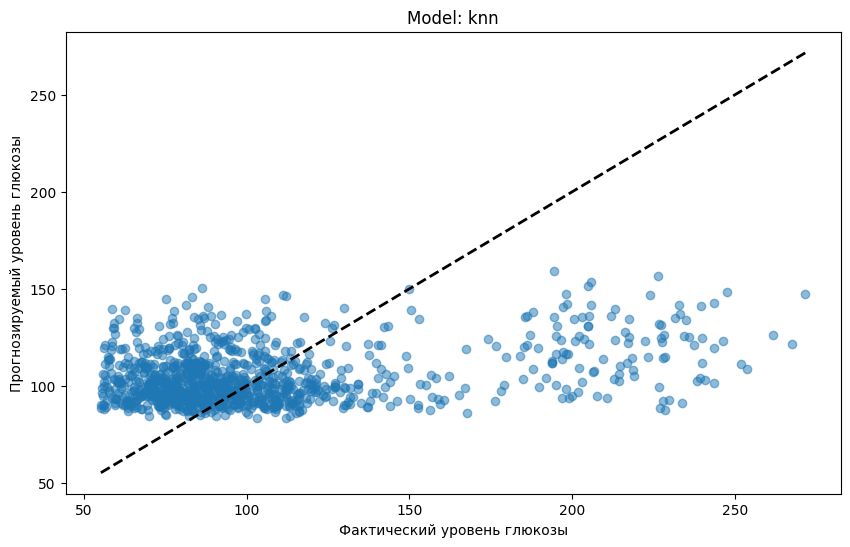

Model: random_forest


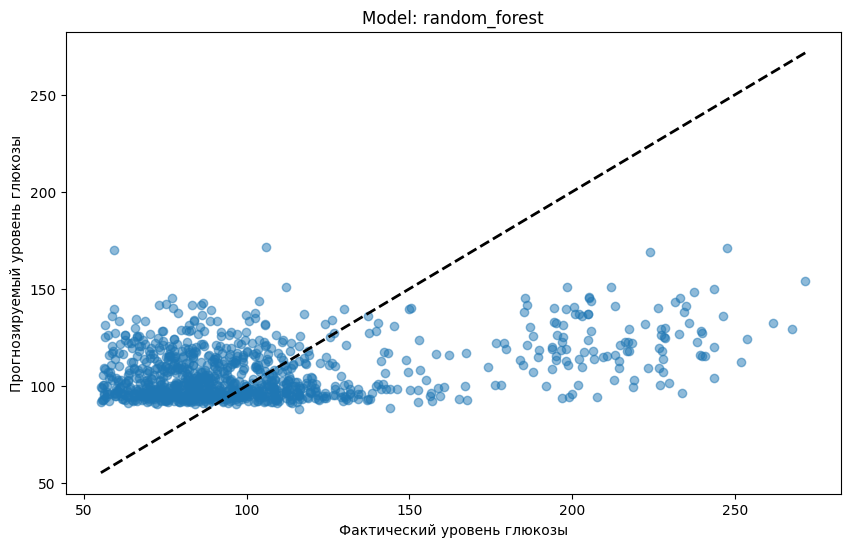

Model: mlp


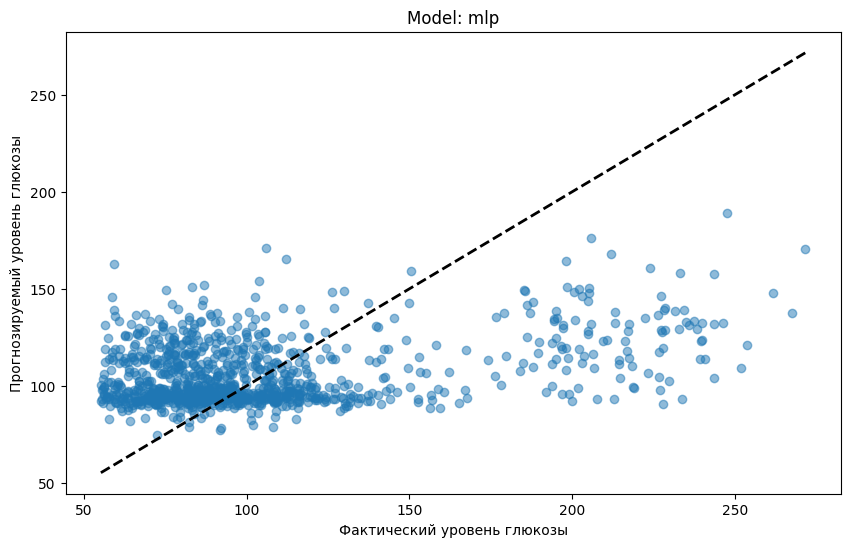

In [18]:
# Создаем графики для всех моделей
for model_name, model_data in class_models.items():
    print(f"Model: {model_name}")
    y_pred = model_data["preds"]
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Фактический уровень глюкозы')
    plt.ylabel('Прогнозируемый уровень глюкозы')
    plt.title(f"Model: {model_name}")
    plt.show()

На представленных графиках можно заметить, что модели в целом не демонстрируют высокого качества. Визуализация их предсказаний показывает сильное рассеивание вокруг идеальной линии y = x, что указывает на значительные отклонения предсказаний от фактических значений.

Тем не менее ориентир, хоть возможно и не столь значительно, каждая из моделей превосходит по всем показателям. Особенно заметное улучшение в 
R2, которая переходит из отрицательного значения в положительное, что говорит о том, что модели хотя бы частично объясняют дисперсию данных. 

Кроме того, можно сказать, что все модели имеет умеренную дисперсию и не сильно подвержены переобучению, потому что разница между RMSE на обучении и тесте незначительна.

Итоговые выводы:
- Наиболее качественная модель: MLP, так как она показывает наименьшее значение RMSE и наибольшее значение R2, что указывает на лучшую точность и объяснение дисперсии целевой переменной.

- Random Forest: Близок по производительности к MLP, с чуть большим RMSE, но является более устойчивой моделью с небольшими отклонениями между обучением и тестом.

- KNN: Худшая модель, демонстрирующая наибольшие ошибки и низкое R2, что указывает на необходимость улучшения или использования другой модели для данной задачи.